In [1]:
%matplotlib inline
import sys
sys.path.append('../src/')

import gc
import json
from pathlib import Path

import feather
import numpy as np
import pandas as pd

from scipy import sparse as sp
from tqdm.notebook import tqdm

from utils import (
    ProductEncoder,
    make_coo_row,
    normalized_average_precision,
    get_shard_path,
    cache_to_feather,
    get_check_users,
)

from predictors import GBMFeatures, GBMPredictor

In [2]:
pd.options.display.max_columns = None

## Collect dataset

In [3]:
def get_gbm_records(shard_indices, gbm_feat, max_records=None, **kwargs):
    gbm_recs = []
    gt_all_recs = []
    num_records = 0
    for shard_idx in tqdm(shard_indices, leave=False):
        for js in tqdm((json.loads(s) for s in open(get_shard_path(shard_idx))), leave=False):
            if js["client_id"] in CHECK_USERS:
                continue

            feat_records, gt_records = gbm_feat.get_gbm_features(js, train=True, **kwargs)
            gbm_recs.extend(feat_records)
            gt_all_recs.append(gt_records)
            num_records += 1
            if max_records and num_records >= max_records:
                return gbm_recs, gt_all_recs
    return gbm_recs, gt_all_recs


In [4]:
CHECK_USERS = get_check_users()
ASSETS_DIR = Path("../submit/solution/assets")

In [5]:
gbm_feat = GBMFeatures(
    product_csv_path=ASSETS_DIR / "products.csv", 
    model_pickled_path=ASSETS_DIR / "model_implicit_cosine_50.pkl",
    products_misc_path=ASSETS_DIR / "products_misc.csv",
    product_features_encoder_path=ASSETS_DIR / "product_features.pkl",
    implicit_tfidf_path=ASSETS_DIR / "model_implicit_tf_idf100.pkl",
    implicit_als_path=ASSETS_DIR / "model_implicit_als_16fact_12iter.pkl",
    implicit_cosine2_path=ASSETS_DIR / "model_implicit_cosine2.pkl",
    umap_item_emb_path=ASSETS_DIR / "umap_item_emb.npy",
    item_co_occurrence_path=ASSETS_DIR / "item_co_occurrence_min_cnt_5.npz",
    item_occurrence_path=ASSETS_DIR / "item_occurrence.npy",
    user_prod_log_idf_path=ASSETS_DIR / "user_prod_log_idf.npy", 
    tran_prod_log_idf_path=ASSETS_DIR / "tran_prod_log_idf.npy", 
    N=100,
#     trunk_svd_arr_path=ASSETS_DIR / "svd_128_components_T.npy",
#     faiss_index_path=str(ASSETS_DIR / "faiss_base.idx"),
#     train_scores_path=ASSETS_DIR / "X_scores_sparse.npz",
#     faiss_neighbors=512,
#     faiss_nprobe=8,
)

In [6]:
# to test pipeline
# MAX_RECORDS = 100
# shards = [14]

# full training
MAX_RECORDS = None
shards = range(15)

In [7]:
train_dir = Path(f"../tmp/train_chunks_{gbm_feat.N}")
train_dir.mkdir(exist_ok=True)

test_dir = Path(f"../tmp/test_chunks_{gbm_feat.N}")
test_dir.mkdir(exist_ok=True)

### Collect and save datasets

In [ ]:
for num_shard in tqdm(shards, leave=False):
    gbm_rec_train, gt_all_rec_train = get_gbm_records([num_shard], gbm_feat, max_records=MAX_RECORDS)
    df_gbm_train_chunk = pd.DataFrame(gbm_rec_train)
    feather.write_dataframe(df_gbm_train_chunk, f"{train_dir}/df_train_{num_shard}.feather")

In [ ]:
df_gbm_train_chunk.head()

In [ ]:
del gbm_rec_train
del df_gbm_train_chunk
gc.collect()

In [ ]:
gbm_rec_test, gt_all_rec_test = get_gbm_records([15], gbm_feat, max_records=MAX_RECORDS)
df_gbm_test = pd.DataFrame(gbm_rec_test)

feather.write_dataframe(df_gbm_test, test_dir / "df_test_15.feather")

In [ ]:
cache_to_feather(gbm_feat.cache_fm_feat)

### Load datasets

In [8]:
dfs = []
for num_shard in tqdm(shards, leave=False):
    if Path(f"{train_dir}/df_train_{num_shard}.feather").exists():
        dfs.append(feather.read_dataframe(f"{train_dir}/df_train_{num_shard}.feather"))
    
df_gbm_train = pd.concat(dfs, sort=False)

In [ ]:
del dfs
gc.collect()

In [9]:
df_gbm_train.shape

(65366136, 80)

In [10]:
df_gbm_train.head(5)

,idx,age,gender,num_transactions,popularity_position,last_transaction_timestamp,num_days_from_last_transaction,purchase_sum,num_uniq_store,mean_num_items,total_bought_items,max_bought_items,mean_days_between_purchases,max_days_between_purchases,days_between_first_and_last_purchase,quantity,items_in_different_transactions,mean_items_in_trans,mean_items_in_trans_log,mean_items_in_history,mean_items_in_trans_log_denom,user_item_idf,user_tran_idf_mult_total_idf,total_items_in_history_pct,item_spent,item_cost,item_is_in_last_transaction,last_item_purchase_num_days,cooc_item_sum_score,cooc_item_mean_score,cooc_mean_from_items,cooc_sum_from_items,cooc_max_from_items,mean_item_days_between_purchase,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,top_item_cosine50_0_score,top_item_cosine50_1_score,top_item_cosine50_2_score,top_item_cosine2_1_score,top_item_tfidf50_1_score,top_item_tfidf50_2_score,top_item_als_0_score,top_item_als_1_score,top_item_als_2_score,als_score,als_pos,tfidf_score,tfidf_pos,cosine50_score,cosine50_pos,cosine2_score,cosine2_pos,co_occurrence_item_norm_max,co_occurrence_item_norm_mean,co_occurrence_item_norm_sum,co_occurrence_item_norm_max_weighted,co_occurrence_item_norm_mean_weighted,co_occurrence_item_norm_sum_weighted,co_occurrence_co_item_norm_max,co_occurrence_co_item_norm_mean,co_occurrence_co_item_norm_sum,co_occurrence_co_item_norm_max_weighted,co_occurrence_co_item_norm_mean_weighted,co_occurrence_co_item_norm_sum_weighted,umap_user_emb_0,umap_user_emb_1,umap_item_emb_0,umap_item_emb_1,umap_user_item_emb_0,umap_user_item_emb_1,item_pct_spent,target,client_id
0,22529,34,2,47,818,6997.0,3,14092.75,2,3.914894,184,13,0.505495,10,91,2.0,2,0.042553,-2.945929,0.010870,0.412359,4.557274,21.599963,0.01087,82.72,41.36,0,48,0.705676,0.352838,4.812845,524.600157,263.008228,10.0,1,1,1,1,105.0,1415,12,0.300,1.998459,0.284839,0.231769,0.148757,0.199866,0.198825,0.243241,0.242227,0.242198,0.122400,90,0.017739,105,0.028088,45,0.014103,21,0.369826,0.014116,1.538671,0.012060,0.000259,0.028235,0.095657,0.003237,0.352838,0.002080,0.000047,0.005075,2.034535,4.986755,0.297915,3.871153,1.166225,4.428954,0.005870,0,0000bcec9c
1,3073,34,2,47,4637,6997.0,3,14092.75,2,3.914894,184,13,0.505495,10,91,2.0,2,0.042553,-2.945929,0.010870,0.412359,5.548171,26.327129,0.01087,94.44,47.22,0,46,0.046776,0.023388,4.812845,524.600157,263.008228,29.0,1,10,18,21,223.0,1308,491,0.521,1.121054,0.187046,0.084517,0.126301,0.076623,0.050840,0.042866,0.042588,0.042562,0.005693,182,0.010919,123,0.012185,85,0.010870,28,0.379793,0.008901,0.970177,0.012385,0.000184,0.020052,0.003552,0.000215,0.023388,0.000057,0.000002,0.000247,2.034535,4.986755,2.229548,4.373875,2.132041,4.680315,0.006701,0,0000bcec9c
2,18949,34,2,47,63,6997.0,3,14092.75,2,3.914894,184,13,0.505495,10,91,0.0,0,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,0.00,74.23,0,-1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1,9,37,130,209.0,395,472,1.000,1.414298,0.174570,0.167986,0.139211,0.175210,0.163482,0.677881,0.673001,0.670037,0.065761,115,0.024766,81,0.001227,170,0.000000,1000,0.270072,0.010311,1.123935,0.008807,0.000189,0.020599,0.084425,0.007057,0.769174,0.000459,0.000059,0.006437,2.034535,4.986755,2.130728,7.824884,2.082632,6.405820,0.000000,0,0000bcec9c
3,28678,34,2,47,5335,6997.0,3,14092.75,2,3.914894,184,13,0.505495,10,91,2.0,1,0.021277,-3.464885,0.005435,0.206179,5.935313,32.812728,0.01087,175.10,87.55,0,55,0.030390,0.030390,4.812845,524.600157,263.008228,-1.0,1,10,15,87,92.0,257,314,0.500,1.437099,0.262388,0.173162,0.218877,0.158338,0.145272,0.034268,0.034011,0.033932,0.016214,162,0.005600,164,0.008342,114,0.005435,42,0.581871,0.011320,1.233918,0.018974,0.000243,0.026451,0.005345,0.000279,0.030390,0.000051,0.000002,0.000256,2.034535,4.986755,1.640399,2.800461,1.837467,3.893608,0.012425,0,0000bcec9c
4,26119,34,2,47,66,6997.0,3,14092.75,2,3.914894,184,13,0.505495,10,91,0.0,0,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,

In [12]:
df_gbm_test = feather.read_dataframe(test_dir / "df_test_15.feather")

gt_all_rec_test = []
for js in tqdm((json.loads(s) for s in open(get_shard_path(15))), leave=False):
    target_products = set(gbm_feat.product_encoder.toIdx([pid for pid in js["target"][0]["product_ids"]]))
    gt_products = dict(
        client_id=js['client_id'],
        products=list(target_products),
    )
    gt_all_rec_test.append(gt_products)

In [13]:
df_gbm_test.shape

(4354858, 80)

In [14]:
df_gbm_test.head()

,idx,age,gender,num_transactions,popularity_position,last_transaction_timestamp,num_days_from_last_transaction,purchase_sum,num_uniq_store,mean_num_items,total_bought_items,max_bought_items,mean_days_between_purchases,max_days_between_purchases,days_between_first_and_last_purchase,quantity,items_in_different_transactions,mean_items_in_trans,mean_items_in_trans_log,mean_items_in_history,mean_items_in_trans_log_denom,user_item_idf,user_tran_idf_mult_total_idf,total_items_in_history_pct,item_spent,item_cost,item_is_in_last_transaction,last_item_purchase_num_days,mean_item_days_between_purchase,cooc_item_sum_score,cooc_item_mean_score,cooc_mean_from_items,cooc_sum_from_items,cooc_max_from_items,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,top_item_cosine50_0_score,top_item_cosine50_1_score,top_item_cosine50_2_score,top_item_cosine2_1_score,top_item_tfidf50_1_score,top_item_tfidf50_2_score,top_item_als_0_score,top_item_als_1_score,top_item_als_2_score,als_score,als_pos,tfidf_score,tfidf_pos,cosine50_score,cosine50_pos,cosine2_score,cosine2_pos,co_occurrence_item_norm_max,co_occurrence_item_norm_mean,co_occurrence_item_norm_sum,co_occurrence_item_norm_max_weighted,co_occurrence_item_norm_mean_weighted,co_occurrence_item_norm_sum_weighted,co_occurrence_co_item_norm_max,co_occurrence_co_item_norm_mean,co_occurrence_co_item_norm_sum,co_occurrence_co_item_norm_max_weighted,co_occurrence_co_item_norm_mean_weighted,co_occurrence_co_item_norm_sum_weighted,umap_user_emb_0,umap_user_emb_1,umap_item_emb_0,umap_item_emb_1,umap_user_item_emb_0,umap_user_item_emb_1,item_pct_spent,target,client_id
0,18949,62,2,17,63,7007.0,3,3873.97,2,3.882353,66,9,0.16,13,100,0.0,0,0.000000,0.00000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.00,74.23,0,-1,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,1,9,37,130,209.0,395,472,1.000,1.414298,0.174570,0.167986,0.139211,0.175210,0.163482,0.677881,0.673001,0.670037,0.034954,106,0.027957,106,0.005069,152,0.000000,1000,0.270072,0.013959,0.697941,0.006975,0.000362,0.018090,0.024123,0.005644,0.282209,0.000751,0.000110,0.005484,1.209901,6.658143,2.130728,7.824884,1.670315,7.241513,0.000000,0,000687035e
1,22535,62,2,17,678,7007.0,3,3873.97,2,3.882353,66,9,0.16,13,100,0.0,0,0.000000,0.00000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.00,15.71,0,-1,-1.0,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,1,12,20,23,230.0,761,223,0.085,1.474182,0.594522,0.440506,0.386675,0.444970,0.360354,0.375053,0.374784,0.374720,0.173161,46,0.037944,63,0.038100,60,0.000000,1000,0.335931,0.026553,1.327666,0.006018,0.000609,0.030450,0.165226,0.013252,0.662583,0.010014,0.000355,0.017726,1.209901,6.658143,0.709701,7.979910,0.959801,7.319026,0.000000,0,000687035e
2,15367,62,2,17,444,7007.0,3,3873.97,2,3.882353,66,9,0.16,13,100,1.0,1,0.058824,-2.67621,0.015152,0.260878,4.173105,18.254445,0.015152,50.82,50.82,0,59,-1.0,0.159905,0.159905,1.32634,66.317006,22.947896,1,12,20,294,230.0,334,38,0.300,2.065179,0.358477,0.202587,0.217977,0.271764,0.160639,0.346393,0.342676,0.342210,0.106549,74,0.026541,109,0.034360,72,0.015152,36,0.283077,0.014620,0.730994,0.007569,0.000371,0.018556,0.012382,0.003198,0.159905,0.000619,0.000063,0.003170,1.209901,6.658143,1.027886,8.127799,1.118894,7.392971,0.013118,0,000687035e
3,4105,62,2,17,9197,7007.0,3,3873.97,2,3.882353,66,9,0.16,13,100,1.0,1,0.058824,-2.67621,0.015152,0.260878,7.059955,26.586849,0.015152,27.17,27.17,0,76,-1.0,0.006380,0.006380,1.32634,66.317006,22.947896,1,10,22,26,132.0,1567,1589,1.500,1.855275,0.198695,0.171339,0.133228,0.093120,0.076321,0.025757,0.025437,0.025435,0.008491,138,0.017552,129,0.028110,83,0.015152,50,0.439446,0.015121,0.756055,0.006658,0.000343,0.017170,0.003107,0.000128,0.006380,0.000047,0.000002,0.000107,1.209901,6.658143,-1.557867,7.950340,-0.173983,7.304241,0.007013,0,000687035e
4,26119,62,2,17,66,7007.0,3,3873.97,2,3.882353,66,9,0.16,13,100,0.0,0,0.000000,0.00000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.00,36.85,0,-1,-1.0,-1.000000,-1

### Add query_id

In [25]:
def get_query_id(df):
    query_map = {}
    for query_id, client_id in enumerate(df['client_id'].unique()):
        query_map[client_id] = query_id
    query_id = df['client_id'].map(query_map)
    return query_id

In [29]:
# to be compatible with CatBoost format
df_gbm_train['query_id'] = get_query_id(df_gbm_train)
df_gbm_test['query_id'] = get_query_id(df_gbm_test)

## Train LGBM

In [30]:
import lightgbm as lgb

In [31]:
drop_cols = ['client_id', 'target', 'query_id', 'lgb_scores']
train_ds = lgb.Dataset(df_gbm_train.drop(drop_cols, errors='ignore', axis=1),
                       df_gbm_train['target'],
                       group=df_gbm_train['query_id'].value_counts().sort_index().values)
test_ds = lgb.Dataset(df_gbm_test.drop(drop_cols, errors='ignore', axis=1),
                      df_gbm_test['target'],
                      group=df_gbm_test['query_id'].value_counts().sort_index().values)

gc.collect()

In [33]:
# to exclude MemoryError
del df_gbm_train
gc.collect()

20

In [36]:
lgb_params = dict(
    objective="binary",
#     objective='lambdarank',
    max_depth=12,
    random_state=42,
    learning_rate=0.1,
    lambda_l2=15,
    metric=("binary", "map"),
    eval_at=30,
    max_bin=63,
    first_metric_only=True,
)
num_boost_round = 3000

In [37]:
gbm = lgb.train(lgb_params, train_ds, num_boost_round, valid_sets=(train_ds, test_ds), verbose_eval=10,
                early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.0663163	training's map@30: 0.403486	valid_1's binary_logloss: 0.0659259	valid_1's map@30: 0.404538
[20]	training's binary_logloss: 0.0645685	training's map@30: 0.405131	valid_1's binary_logloss: 0.0642281	valid_1's map@30: 0.406323
[30]	training's binary_logloss: 0.0640139	training's map@30: 0.405938	valid_1's binary_logloss: 0.0636932	valid_1's map@30: 0.407254
[40]	training's binary_logloss: 0.0637196	training's map@30: 0.406998	valid_1's binary_logloss: 0.0634112	valid_1's map@30: 0.408162
[50]	training's binary_logloss: 0.0635314	training's map@30: 0.407788	valid_1's binary_logloss: 0.0632367	valid_1's map@30: 0.40861
[60]	training's binary_logloss: 0.0633819	training's map@30: 0.40878	valid_1's binary_logloss: 0.0631088	valid_1's map@30: 0.409524
[70]	training's binary_logloss: 0.0632722	training's map@30: 0.409461	valid_1's binary_logloss: 0.0630214	valid_1's map@30: 0.409802
[80]	trai

[620]	training's binary_logloss: 0.062162	training's map@30: 0.417737	valid_1's binary_logloss: 0.0622696	valid_1's map@30: 0.414883
[630]	training's binary_logloss: 0.0621521	training's map@30: 0.417801	valid_1's binary_logloss: 0.0622655	valid_1's map@30: 0.414963
[640]	training's binary_logloss: 0.0621451	training's map@30: 0.417854	valid_1's binary_logloss: 0.0622706	valid_1's map@30: 0.414973
[650]	training's binary_logloss: 0.0621363	training's map@30: 0.417918	valid_1's binary_logloss: 0.0622663	valid_1's map@30: 0.414988
[660]	training's binary_logloss: 0.0621276	training's map@30: 0.418018	valid_1's binary_logloss: 0.0622629	valid_1's map@30: 0.415035
[670]	training's binary_logloss: 0.0621207	training's map@30: 0.418092	valid_1's binary_logloss: 0.0622589	valid_1's map@30: 0.415049
[680]	training's binary_logloss: 0.0621128	training's map@30: 0.418155	valid_1's binary_logloss: 0.062256	valid_1's map@30: 0.414971
[690]	training's binary_logloss: 0.0621059	training's map@30: 0.

[1240]	training's binary_logloss: 0.0617527	training's map@30: 0.421328	valid_1's binary_logloss: 0.0621532	valid_1's map@30: 0.415869
[1250]	training's binary_logloss: 0.0617473	training's map@30: 0.421376	valid_1's binary_logloss: 0.0621516	valid_1's map@30: 0.415882
[1260]	training's binary_logloss: 0.0617412	training's map@30: 0.421422	valid_1's binary_logloss: 0.0621517	valid_1's map@30: 0.415903
[1270]	training's binary_logloss: 0.0617361	training's map@30: 0.421475	valid_1's binary_logloss: 0.0621509	valid_1's map@30: 0.415898
[1280]	training's binary_logloss: 0.0617318	training's map@30: 0.421534	valid_1's binary_logloss: 0.0621498	valid_1's map@30: 0.41582
[1290]	training's binary_logloss: 0.0617253	training's map@30: 0.421577	valid_1's binary_logloss: 0.0621474	valid_1's map@30: 0.415853
[1300]	training's binary_logloss: 0.0617196	training's map@30: 0.42162	valid_1's binary_logloss: 0.0621474	valid_1's map@30: 0.41578
[1310]	training's binary_logloss: 0.0617133	training's map

[1850]	training's binary_logloss: 0.0614336	training's map@30: 0.424189	valid_1's binary_logloss: 0.0621101	valid_1's map@30: 0.41616
[1860]	training's binary_logloss: 0.0614289	training's map@30: 0.424234	valid_1's binary_logloss: 0.0621102	valid_1's map@30: 0.41608
[1870]	training's binary_logloss: 0.0614246	training's map@30: 0.424266	valid_1's binary_logloss: 0.0621092	valid_1's map@30: 0.41598
[1880]	training's binary_logloss: 0.0614185	training's map@30: 0.424307	valid_1's binary_logloss: 0.0621075	valid_1's map@30: 0.41594
[1890]	training's binary_logloss: 0.0614137	training's map@30: 0.42435	valid_1's binary_logloss: 0.0621074	valid_1's map@30: 0.415881
[1900]	training's binary_logloss: 0.0614084	training's map@30: 0.424395	valid_1's binary_logloss: 0.0621054	valid_1's map@30: 0.415912
[1910]	training's binary_logloss: 0.0614033	training's map@30: 0.424461	valid_1's binary_logloss: 0.062105	valid_1's map@30: 0.415933
[1920]	training's binary_logloss: 0.0613984	training's map@30

In [38]:
drop_cols = ['client_id', 'target', 'lgb_scores', 'query_id']
lgb_scores = gbm.predict(df_gbm_test.drop(drop_cols, axis=1, errors='ignore'))

df_gbm_test['lgb_scores'] = lgb_scores

In [39]:
lgb_ranked = df_gbm_test.groupby('client_id')[['idx', 'lgb_scores']].apply(
    lambda x: x.sort_values('lgb_scores', ascending=False)[:30]['idx'].tolist()).to_dict()

In [40]:
gt_test = {item['client_id']: item['products'] for item in gt_all_rec_test}

In [41]:
scores = []
for client_id, recommended_idx in lgb_ranked.items():
    ap = normalized_average_precision(gt_test[client_id], recommended_idx)
    scores.append(ap)
model_score = np.mean(scores)
print(model_score)

0.15311582164391252


In [42]:
params_str = '__'.join('_'.join(map(str, item)) for item in gbm.params.items() if item[0] != 'metric')
model_filename = f"lgbm_model__pool_{gbm_feat.N}__{params_str}__{model_score:.6f}.txt"
model_path = str(ASSETS_DIR / model_filename)
gbm.save_model(model_path)
print(model_path)

../submit/solution/assets/lgbm_model__pool_100__objective_binary__max_depth_12__random_state_42__learning_rate_0.1__lambda_l2_15__eval_at_30__max_bin_63__0.153116.txt


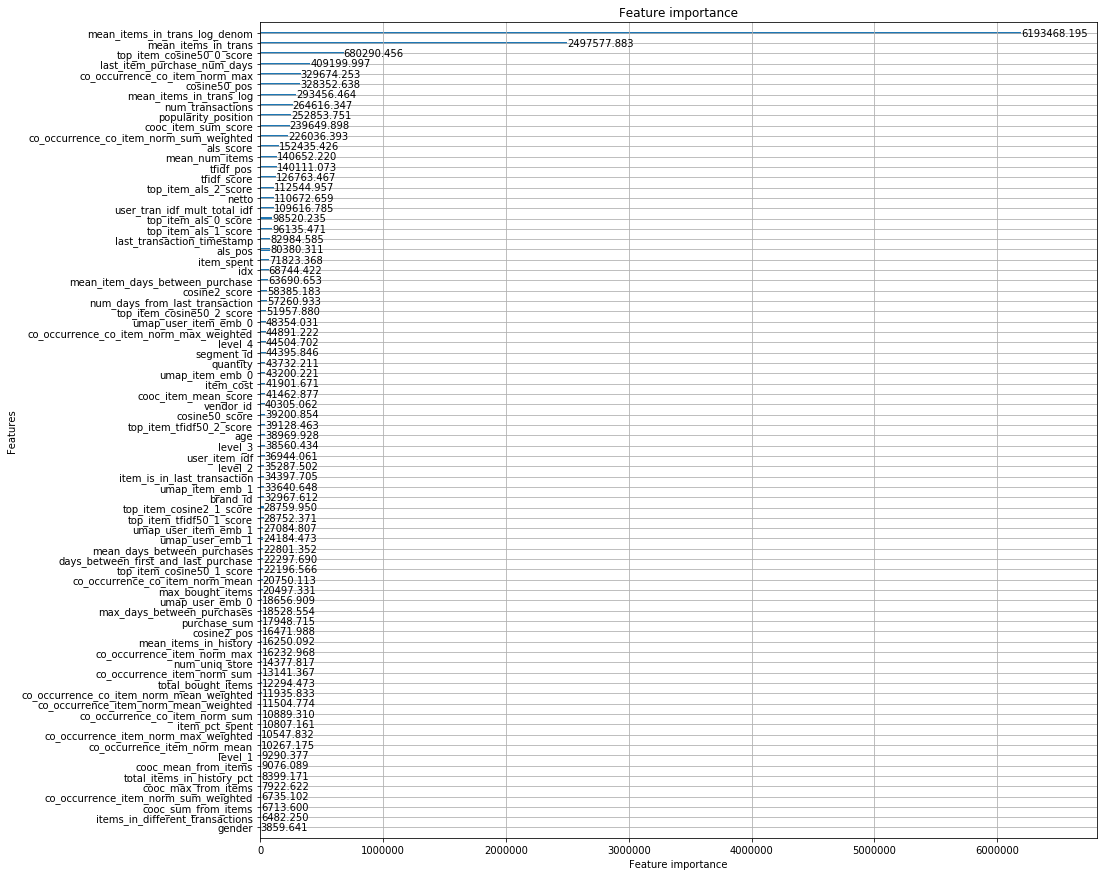

In [43]:
lgb.plot_importance(gbm, figsize=(15, 15), importance_type='gain')

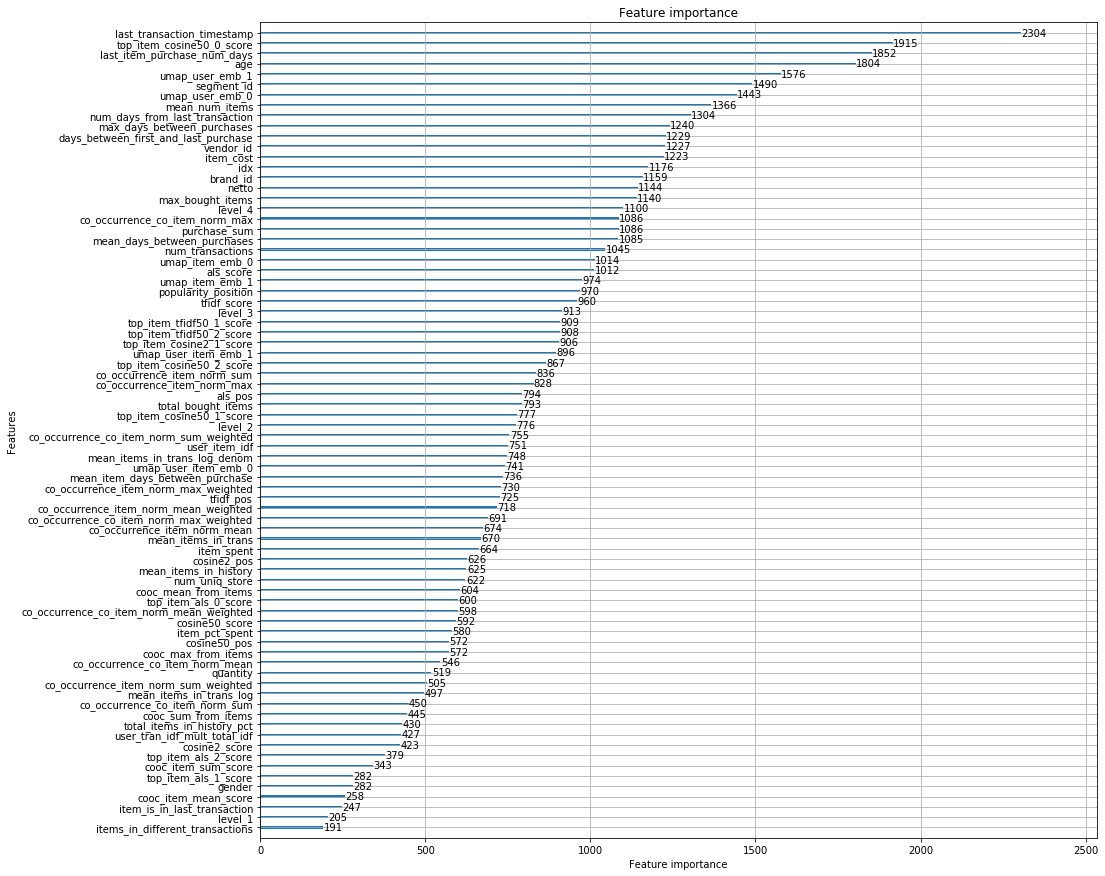

In [44]:
lgb.plot_importance(gbm, figsize=(15, 15), importance_type='split')

## Check predictor

In [45]:
PREDICTOR = GBMPredictor(
    lgbm_model_path=str(ASSETS_DIR / model_filename),
    product_csv_path=ASSETS_DIR / "products.csv", 
    model_pickled_path=ASSETS_DIR / "model_implicit_cosine_50.pkl",
    products_misc_path=ASSETS_DIR / "products_misc.csv",
    product_features_encoder_path=ASSETS_DIR / "product_features.pkl",
    implicit_tfidf_path=ASSETS_DIR / "model_implicit_tf_idf100.pkl",
    implicit_als_path=ASSETS_DIR / "model_implicit_als_16fact_12iter.pkl",
    fm_features_feather_path=ASSETS_DIR / "implicit_scores.feather",
    implicit_cosine2_path=ASSETS_DIR / "model_implicit_cosine2.pkl",
    umap_item_emb_path=ASSETS_DIR / "umap_item_emb.npy",
    item_co_occurrence_path=ASSETS_DIR / "item_co_occurrence_min_cnt_5.npz",
    item_occurrence_path=ASSETS_DIR / "item_occurrence.npy",
    user_prod_log_idf_path=ASSETS_DIR / "user_prod_log_idf.npy", 
    tran_prod_log_idf_path=ASSETS_DIR / "tran_prod_log_idf.npy", 
    N=100,
    # trunk_svd_arr_path=ASSETS_DIR / "svd_128_components_T.npy",
    # faiss_index_path=str(ASSETS_DIR / "faiss_base.idx"),
    # train_scores_path=ASSETS_DIR / "X_scores_sparse.npz",
    # faiss_neighbors=512,
    # faiss_nprobe=8,
)

In [46]:
def evalute_queries(queryset_file, max_records=1000):
    check_scores = []
    with open(queryset_file) as fin:
        for i, line in enumerate(tqdm(fin)):
            splitted = line.strip().split('\t')
            if len(splitted) == 1:
                query_data = json.loads(splitted[0])
                next_transaction = query_data['target'][0]
            else:
                query_data, next_transaction = map(json.loads, splitted)
                query_data['target'] = [next_transaction]

            query_data['transaction_history'] = sorted(query_data['transaction_history'], key=lambda x: x['datetime'])
            recommended_items = PREDICTOR.predict(query_data, PREDICTOR.lgb_model)

            gt_items = query_data["target"][0]["product_ids"]
            nap = normalized_average_precision(gt_items, recommended_items)
            check_scores.append(nap)
            
            if i == max_records:
                break
    return np.mean(check_scores)

In [47]:
queryset_file = "../data/raw/check_queries.tsv"
evalute_queries(queryset_file)

0.1311501051008402

In [48]:
max_records = 1000
queryset_file = "../tmp/jsons/15.jsons.splitted"
evalute_queries(queryset_file, max_records=max_records)

0.14693238031379444